In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet('../data/cleaned_data/data_with_all_weather.parquet', engine='pyarrow')

In [ ]:
data.to_parquet('../data/cleaned_data/data_with_all_weather.parquet', engine='pyarrow', compression='gzip')

Cancellation code

| Code | Description          |
|------|----------------------|
| A    | Carrier              |
| B    | Weather              |
| C    | National Air System  |
| D    | Security             |

In [16]:
# Flights with cancellation code are all cancelled
assert not (data[data['CANCELLATION_CODE'].notna()]['CANCELLED'] == 0).sum()
# Cancelled flights all have cancellation code
assert not data[data['CANCELLED'] == 1]['CANCELLATION_CODE'].isna().sum()
print('Cancellation proportion:', f"{round((data['CANCELLED'].sum() / len(data)) * 100, 3)}%")

Cancellation proportion: 1.943%


In [25]:
cancellation_info = data['CANCELLATION_CODE'].value_counts().reset_index()
cancellation_info.columns = ['Cancellation_Code', 'Count']
cancellation_info['Proportion'] = round((cancellation_info['Count'] / len(data)) * 100, 3)
cancellation_info

,Cancellation_Code,Count,Proportion
0,B,121900,1.114
1,A,71848,0.657
2,C,16659,0.152
3,D,2139,0.020


In [32]:
weather_cancelled_flights = data[data['CANCELLATION_CODE'] == 'B']
print("Weather cancel with a weather code",
       f"{round((weather_cancelled_flights['wxcodes'].notna() | 
           weather_cancelled_flights['wxcodes_arr'].notna()).sum() / len(weather_cancelled_flights), 3) * 100}%")

Weather cancel with a weather code 67.4%


Cancel and delay indicator series

In [33]:
cancelled = data['CANCELLED'] == 1
delayed = data['ARR_TIMESTAMP'] > data['CRS_ARR_TIMESTAMP']
delayed = delayed | cancelled

Airport size classify

In [3]:
airport_counts = data['ORIGIN'].value_counts().reset_index()
airport_counts.columns = ['airport', 'count']
airport_counts

,airport,count
0,ATL,528489
1,ORD,483984
2,DFW,431107
3,DEN,421338
4,CLT,356207
...,...,...
380,ROP,31
381,IFP,31
382,ILG,26
383,ACK,25


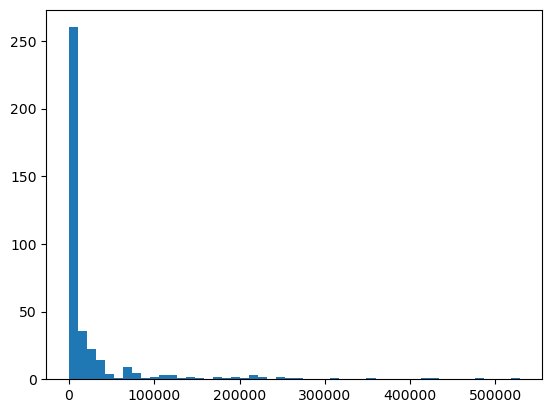

In [22]:
plt.hist(airport_counts['count'], bins=50)
plt.show()

We define small airport as flight count smaller than 10k, medium airport as flight count between 10k and 100k, large airport  as flight count larger than 100k.

In [4]:
def categorize_airport(count):
    if count > 100e3:
        return 'Large'
    elif count > 10e3:
        return 'Medium'
    else:
        return 'Small'
    
airport_counts['size'] = airport_counts['count'].apply(categorize_airport)
airport_counts

,airport,count,size
0,ATL,528489,Large
1,ORD,483984,Large
2,DFW,431107,Large
3,DEN,421338,Large
4,CLT,356207,Large
...,...,...,...
380,ROP,31,Small
381,IFP,31,Small
382,ILG,26,Small
383,ACK,25,Small


Try to fill NA values and fit logistic model

In [ ]:
features = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'vsby', 'alti', 'mslp', 
            'tmpf_arr', 'dwpf_arr', 'relh_arr', 'drct_arr', 'sknt_arr', 'p01i_arr', 'vsby_arr', 'alti_arr', 'mslp_arr']

not_cancelled_flights = data[data['CANCELLED'] == 0].sample(len(weather_cancelled_flights))
balanced_data = pd.concat([weather_cancelled_flights, not_cancelled_flights])
X = balanced_data[features]
y = balanced_data['CANCELLED']

In [ ]:
from sklearn.impute import KNNImputer
X = X.groupby(data['ORIGIN']).apply(lambda group: group.fillna(group.median()))
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

In [46]:
data_imputed = data[features].groupby(data['ORIGIN']).apply(lambda group: group.fillna(group.median()))
# data_imputed.to_parquet('../data/cleaned_data/data_with_all_weather_imputed.parquet', engine='pyarrow', compression='gzip')

In [52]:
data_imputed

tmpf  dwpf   relh   drct  sknt  p01i  vsby   alti    mslp  \
ORIGIN                                                                       
ABE    776        6.0  -6.0  56.68  290.0   5.0   0.0  10.0  30.37  1029.5   
       1349       6.0  -6.0  56.68  290.0   5.0   0.0  10.0  30.37  1029.5   
       1591       6.0  -6.0  56.68  290.0   5.0   0.0  10.0  30.37  1029.5   
       1601       6.0  -6.0  56.68  290.0   5.0   0.0  10.0  30.37  1029.5   
       4630       8.1  -4.0  57.00  290.0   6.0   0.0  10.0  30.41  1030.5   
...               ...   ...    ...    ...   ...   ...   ...    ...     ...   
YUM    10907170   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN     NaN   
       10912922   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN     NaN   
       10923888   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN     NaN   
       10924633   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN     NaN   
       10930474   NaN   NaN    NaN    NaN   NaN   NaN   NaN    NaN     NaN   

                 tmpf_arr  dwpf_arr  relh_arr  drct_arr  sknt_arr  p01i_arr  \
ORIGIN                                                                        
ABE    776           19.0       6.0     56.57     340.0      14.0    0.0000   
       1349           7.0      -5.0     56.83     260.0       6.0    0.0000   
       1591          -9.0     -17.0     66.99     290.0       9.0    0.0000   
       1601          19.9       1.9     44.87      30.0       9.0    0.0000   
       4630          10.0      -0.9     60.64     290.0      15.0    0.0001   
...                   ...       ...       ...       ...       ...       ...   
YUM    10907170      56.0      36.0     46.88      70.0       3.0    0.0000   
       10912922      78.0      34.0     20.23       0.0       0.0    0.0000   
       10923888      60.0      45.0     57.58       0.0       0.0    0.0000   
       10924633      58.0      39.0     49.08     120.0       5.0    0.0000   
       10930474      78.0      42.0     27.69     140.0       6.0    0.0000   

                 vsby_arr  alti_arr  mslp_arr  
ORIGIN                                         
ABE    776           10.0     30.40    1031.0  
       1349          10.0     30.45    1031.1  
       1591          10.0     30.67    1040.6  
       1601          10.0     30.50    1033.5  
       4630          10.0     30.53    1035.2  
...                   ...       ...       ...  
YUM    10907170      10.0     30.08    1017.6  
       10912922      10.0     30.02    1015.4  
       10923888      10.0     30.25    1023.9  
       10924633      10.0     30.06    1017.0  
       10930474      10.0     29.97    1013.7  

[10939582 rows x 18 columns]

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
model = LogisticRegression(max_iter=500)
scaler = StandardScaler()
X = scaler.fit_transform(X)
model.fit(X, y)

LogisticRegression(max_iter=500)

In [40]:
model.coef_

array([[-0.63658867,  0.47430343, -0.36426138,  0.08704096,  0.03722446,
         0.08743087, -0.08605384, -0.2168234 ,  0.18714852, -0.05996098,
         0.18768251, -0.01126526,  0.02290828,  0.03585923,  0.01633441,
         0.02451882,  0.26713665, -0.19877185]])

In [ ]:
cancel_preditct = model.predict(scaler.fit_transform(data[data[features].notna()]))

In [3]:
data.columns

Index(['OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'DEST', 'DEST_CITY_NAME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIMESTAMP',
       'CRS_ARR_TIMESTAMP', 'DEP_TIMESTAMP', 'ARR_TIMESTAMP', 'CRS_DEP_UTC',
       'CRS_ARR_UTC', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'vsby',
       'alti', 'mslp', 'wxcodes', 'tmpf_arr', 'dwpf_arr', 'relh_arr',
       'drct_arr', 'sknt_arr', 'p01i_arr', 'vsby_arr', 'alti_arr', 'mslp_arr',
       'wxcodes_arr'],
      dtype='object')

In [7]:
data_flights = data[['ORIGIN', 'DEST', 'CANCELLED', 'CRS_DEP_TIMESTAMP']].copy()
data_flights['DELAY_TIME'] = (data['ARR_TIMESTAMP'] - data['CRS_ARR_TIMESTAMP']).dt.total_seconds() / 60
data_flights['DELAY_TIME'] = data_flights['DELAY_TIME'].fillna(pd.NA)
aiports_lookup = data[['ORIGIN', 'ORIGIN_CITY_NAME']].drop_duplicates().reset_index(drop=True)

In [ ]:
data_flights = data_flights[data_flights['ORIGIN'].isin(airport_counts[airport_counts['size'] == 'Large']['airport'])]

In [15]:
data_flights.to_csv('./shiny/data_flights.csv', index=False)
aiports_lookup.to_csv('./shiny/airports_lookup.csv', index=False)